<a href="https://colab.research.google.com/github/spnadig/sensor_intelligence/blob/main/autoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install allantools
# !pip install tensorflow
# !pip install matplotlib
# !pip install pandas
# !pip install scipy

In [5]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models


In [2]:
#@markdown - 3 axis of sensor, 1 temperature vs time <br> input dim:  samples x 4; 100x4 <br>
#@markdown - 1st layer (short term) -- kernel(20x4) for each feature (5) (bias, SF, temp_resp, white_noise, rate) <br>
#@markdown - 2nd layer (long term) -- kernel(60x4) <br>
#@markdown - NEED TO NORMALIZE TIME DOMAIN INPUT CH <br>
#@markdown - OUTPUT will be noise_free data - mse of (prediction - noise_free input)


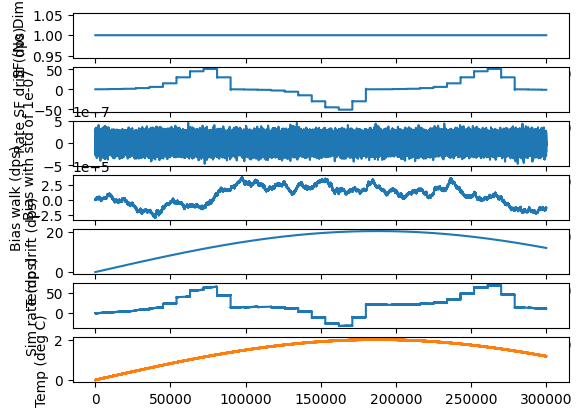

In [6]:
#@title create DF
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as scipy_signal
import time
# import allantools

def generate_sim_rates(profile_type, fs=100.0, amplitude_deg=60.0,
                        wn_hz=200.0, zeta=0.7,
                        sf_ppm_std=5000.0*0.0, bias_walk_std=0.0001*0.0,
                        temp_coeff=1.0, wn_std=0.05,
                        temp_cycle_period=1200.0, full_gyro_scale=200,
                        temp_noise_std=0.8*0.0,
                        simEndTime=10.0, pre_append_rest_duration = 0.0, showContriPlots = False):

    dt = 1.0 / fs
    rest_duration = pre_append_rest_duration  # seconds
    total_time = simEndTime + rest_duration
    max_amp = 0.85 * full_gyro_scale
    amp = np.clip(amplitude_deg, -max_amp, max_amp)

    u = []
    base_u = []

    # -- Rest segment (prepend later) --
    u_rest = np.zeros(int(rest_duration / dt))

    # -- Signal generation --
    if profile_type == "rest":
        u = np.zeros(int(simEndTime / dt))

    elif profile_type == "step":
        t1 = np.arange(0, 2.0, dt)
        t2 = np.arange(0, 3.0, dt)
        t3 = np.arange(0, 2.0, dt)
        base_u = np.concatenate([
            np.zeros_like(t1),
            np.full_like(t2, amp),
            np.zeros_like(t3)
        ])

    elif profile_type == "freq":
        freqs = np.logspace(np.log10(0.1), np.log10(20.0), 15)
        base_u = []
        for f in freqs:
            cycles = 10 if f < 1 else 20 if f < 10 else 30
            duration = cycles / f
            t = np.arange(0, duration, dt)
            signal = amp * np.sin(2 * np.pi * f * t)
            base_u.append(signal)
        base_u = np.concatenate(base_u)

    elif profile_type == "stair":
        levels = [
            0.0, 0.01, 0.02, 0.05, 0.10, 0.25, 0.50, 0.75, 0.85,
            0.50, 0.0, -0.01, -0.02, -0.05, -0.10, -0.25, -0.50, -0.75, -0.85, -0.50, 0.0
        ]
        dwell_time = 3.0
        for lvl in levels:
            base_u.extend([lvl * amp] * int(dwell_time / dt))
        base_u = np.array(base_u)

    elif profile_type == "ramp_sym":
        slope = 150.0
        ramp_time = amp / slope
        t1 = np.arange(0, ramp_time, dt)
        t2 = np.arange(0, 5.0, dt)
        t3 = np.arange(0, 2 * ramp_time, dt)
        t4 = np.arange(0, 5.0, dt)
        t5 = np.arange(0, ramp_time, dt)
        t6 = np.arange(0, 1.0, dt)
        base_u = np.concatenate([
            slope * t1,
            np.full_like(t2, amp),
            np.linspace(amp, -amp, t3.size),
            np.full_like(t4, -amp),
            np.linspace(-amp, 0.0, t5.size),
            np.zeros_like(t6)
        ])

    elif profile_type == "ramp_saw":
        slope = 100.0
        ramp_time = amp / slope
        t_total = np.arange(0, 3 * ramp_time + 5.0, dt)
        ramp = np.zeros_like(t_total)
        p1 = int(ramp_time / dt)
        p2 = 2 * p1
        p3 = 3 * p1
        ramp[:p1] = np.linspace(0, amp, p1)
        ramp[p1:p2] = np.linspace(amp, -amp, p1)
        ramp[p2:p3] = np.linspace(-amp, 0.0, p1)
        f_min, f_max = 1.0, 5.0
        f_t = f_min + (f_max - f_min) * (t_total / t_total[-1])
        saw = 0.01 * full_gyro_scale * (2 * (t_total * f_t % 1) - 1)
        base_u = np.clip(ramp + saw, -max_amp, max_amp)

    elif profile_type == "step_saw":
        duration = 10.0
        hold_time = 2.0
        t_total = np.arange(0, duration, dt)
        step_val = 0.75 * amp
        hold_samples = int(hold_time / dt)
        u_hold = np.zeros(hold_samples)
        ripple_samples = len(t_total) - hold_samples
        f_min, f_max = 0.5, 10.0
        f_t = f_min + (f_max - f_min) * (np.arange(ripple_samples) * dt / (duration - hold_time))
        saw = 0.01 * full_gyro_scale * (2 * (np.arange(ripple_samples) * dt * f_t % 1) - 1)
        u_ripple = step_val + saw
        base_u = np.concatenate([u_hold, u_ripple])

    else:
        raise ValueError("Unsupported profile_type")

    if profile_type != "rest":
        reps = int(np.ceil(simEndTime / (len(base_u) * dt)))
        signal_u = np.tile(base_u, reps)[:int(simEndTime / dt)]
        u = np.concatenate([u_rest, signal_u])
    else:
        u = np.concatenate([u_rest, u])

    t = np.arange(0, len(u)) * dt

    wn_rad = 2 * np.pi * wn_hz
    num = [wn_rad**2]
    den = [1, 2 * zeta * wn_rad, wn_rad**2]
    sys = scipy_signal.TransferFunction(num, den)
    sys_d = sys.to_discrete(dt, method='bilinear')
    y_dyn = scipy_signal.dlsim(sys_d, u)[1].flatten()

    N = len(y_dyn)
    sf_drift = 1.0 + np.random.normal(0, sf_ppm_std * 1e-6, size=N)

    bias = np.random.normal(0, bias_walk_std, size=N)
    bias_walk = np.cumsum(bias)
    #bias_walk = 0.75*np.ones(N)

    temp_true = 2 * np.sin(2 * np.pi * t / temp_cycle_period) # Change from ref temp
    temp_noise = np.random.normal(0, temp_noise_std, size=N)
    temp_measured = temp_true + temp_noise
    temp_drift = temp_coeff * temp_true

    white_noise = np.random.normal(0, wn_std, size=N)

    y_sim = sf_drift * y_dyn + bias_walk + temp_drift + white_noise
    y_true = u

    if showContriPlots:
        fig, axs = plt.subplots(7,1)
        axs[0].plot(sf_drift)
        axs[0].set_ylabel('SF (No Dim)')
        axs[1].plot(sf_drift * y_dyn)
        axs[1].set_ylabel('Rate SF drift (dps)')
        axs[2].plot(bias)
        axs[2].set_ylabel('Bias with std of {}'.format(bias_walk_std))
        axs[3].plot(bias_walk)
        axs[3].set_ylabel('Bias walk (dps)')
        axs[4].plot(temp_drift)
        axs[4].set_ylabel('Temp drift (dps)')
        axs[6].plot(temp_true, label='True temp')
        axs[6].plot(temp_measured, label='Measured temp')
        axs[6].set_ylabel('Temp (deg C)')
        axs[5].plot(y_sim)
        axs[5].set_ylabel('Sim rate (dps)')
        plt.show()

    return pd.DataFrame({
        "time": t,
        "true_rate_x": 0.25*y_true,
        "true_rate_y": 0.45*y_true,
        "true_rate_z": y_true,
        "sim_rate_x": 0.25*y_sim,
        "sim_rate_y": 0.45*y_sim,
        "sim_rate_z": y_sim,
        "TEMP": temp_measured,
        "TEMP_TRUE": temp_true
    })
df1 = generate_sim_rates(profile_type='rest', fs=3000.0, bias_walk_std=0.000, temp_coeff=0.12, amplitude_deg=60.0, temp_noise_std=0.005, simEndTime=100.0)
df2 = generate_sim_rates(profile_type='step', fs=3000.0, bias_walk_std=0.00, temp_coeff=0.02, amplitude_deg=60.0, temp_noise_std=0.005, simEndTime=100.0)
df3 = generate_sim_rates(profile_type='stair', fs=3000.0, bias_walk_std=1e-7, temp_coeff=10.25, temp_cycle_period=250, amplitude_deg=60.0, temp_noise_std=0.005, simEndTime=100.0, showContriPlots=True)
df = pd.DataFrame()
df = pd.concat([df, df1], ignore_index=True)
df = pd.concat([df, df2], ignore_index=True)
df = pd.concat([df, df3], ignore_index=True)




In [4]:
df.tail(10)
# plt.plot(df['TEMP_TRUE'])
# plt.plot(df['TEMP'])

,time,true_rate_x,true_rate_y,true_rate_z,sim_rate_x,sim_rate_y,sim_rate_z,TEMP,TEMP_TRUE
899990,99.996667,-0.3,-0.54,-1.2,2.688087,4.838557,10.752349,1.183971,1.175706
899991,99.997000,-0.3,-0.54,-1.2,2.716061,4.888910,10.864245,1.185860,1.175692
899992,99.997333,-0.3,-0.54,-1.2,2.745059,4.941105,10.980234,1.179190,1.175679
899993,99.997667,-0.3,-0.54,-1.2,2.720039,4.896070,10.880154,1.171425,1.175665
899994,99.998000,-0.3,-0.54,-1.2,2.701115,4.862008,10.804461,1.172797,1.175652
899995,99.998333,-0.3,-0.54,-1.2,2.714118,4.885413,10.856472,1.182621,1.175638
899996,99.998667,-0.3,-0.54,-1.2,2.745192,4.941346,10.980768,1.172273,1.175625
899997,99.999000,-0.3,-0.54,-1.2,2.717401,4.891322,10.869605,1.177898,1.175611
899998,99.999333,-0.3,-0.54,-1.2,2.710529,4.878952,10.842116,1.172971,1.175598
899999,99.999667,-0.3,-0.54,-1.2,2.728088,4.910558,10.912352,1.186697,1.175584


In [7]:
#@title Dataset
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing

# --- CONFIG ---
sequence_length = 32
feature_dim = 4
batch_size = 2
random_seed = 42

# --- INPUT DATA ---
# Assume df is already defined
feature_cols = ['sim_rate_x', 'sim_rate_y', 'sim_rate_z', 'TEMP']
label_cols = ['true_rate_x', 'true_rate_y', 'true_rate_z', 'TEMP_TRUE']

# --- SCALE FEATURES & LABELS SEPARATELY ---
feature_scaler = preprocessing.MinMaxScaler()
label_scaler = preprocessing.MinMaxScaler()

features = feature_scaler.fit_transform(df[feature_cols].values)
labels = label_scaler.fit_transform(df[label_cols].values)

# --- CREATE SEQUENCES ---
def create_sequences(features, labels, sequence_length):
    X, Y = [], []
    for i in range(len(features) - sequence_length + 1):
        X.append(features[i:i+sequence_length])
        Y.append(labels[i:i+sequence_length])
    return np.array(X), np.array(Y)

X_sequences, y_sequences = create_sequences(features, labels, sequence_length)

# --- SHUFFLE SEQUENCES ---
np.random.seed(random_seed)
sequence_indices = np.arange(len(X_sequences))
np.random.shuffle(sequence_indices)

X_sequences = X_sequences[sequence_indices]
y_sequences = y_sequences[sequence_indices]

# --- SPLIT TRAIN/TEST ---
split_index = int(len(X_sequences) * 0.8)

X_train_sequences = X_sequences[:split_index]
y_train_targets = y_sequences[:split_index]

X_test_sequences = X_sequences[split_index:]
y_test_targets = y_sequences[split_index:]

# --- CREATE TENSORFLOW DATASETS ---
train_ds = tf.data.Dataset.from_tensor_slices((X_train_sequences, y_train_targets)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((X_test_sequences, y_test_targets)).batch(batch_size)


# --- DEBUG PRINT ---
for x, y in train_ds.take(1):
    print("Input batch shape:", x.shape)   # (batch_size, sequence_length, feature_dim)
    print("Target batch shape:", y.shape)  # (batch_size, sequence_length, feature_dim)

# --- OPTIONAL: SHOW SAMPLE ---
for k in train_ds.take(1):
    print('------X-----------')
    print(k[0])  # Features
    print('------Y-----------')
    print(k[1])  # Labels

Input batch shape: (2, 32, 4)
Target batch shape: (2, 32, 4)
------X-----------
tf.Tensor(
[[[0.31413521 0.31413521 0.31413521 0.02327847]
  [0.31553155 0.31553155 0.31553155 0.02860726]
  [0.31534702 0.31534702 0.31534702 0.02951952]
  [0.31511519 0.31511519 0.31511519 0.02736223]
  [0.31499564 0.31499564 0.31499564 0.02454538]
  [0.3160427  0.3160427  0.3160427  0.02673609]
  [0.3149215  0.3149215  0.3149215  0.02578512]
  [0.31595773 0.31595773 0.31595773 0.02554204]
  [0.3153104  0.3153104  0.3153104  0.02508923]
  [0.31484155 0.31484155 0.31484155 0.02680723]
  [0.31551263 0.31551263 0.31551263 0.02801256]
  [0.31478312 0.31478312 0.31478312 0.02885433]
  [0.31535554 0.31535554 0.31535554 0.0261233 ]
  [0.31483634 0.31483634 0.31483634 0.02345825]
  [0.3156612  0.3156612  0.3156612  0.02726398]
  [0.31509576 0.31509576 0.31509576 0.02601849]
  [0.31525948 0.31525948 0.31525948 0.02652516]
  [0.31525187 0.31525187 0.31525187 0.02914074]
  [0.31585755 0.31585755 0.31585755 0.0278107

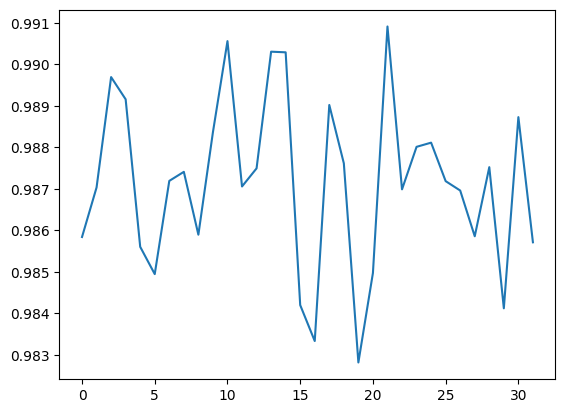

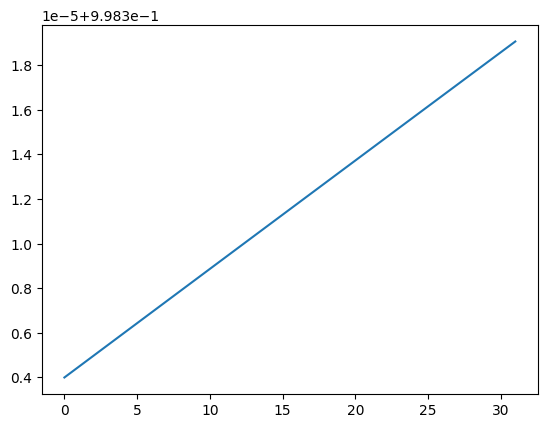

In [6]:
import matplotlib.pyplot as plt
pick = train_ds.take(5)
pick = pick.shuffle(buffer_size=100)
for x, y in pick.take(1):
  plt.plot(x[0,:,3])
  plt.show()
  plt.plot(y[0,:,3])
  plt.show()

In [ ]:
#@title [TEST] SEQUENCE MODEL
model = models.Sequential()
# kernel doesnt need to explicitly mention channel depth
#ENCODER
model.add(layers.Conv1D(filters = 5, kernel_size = 20, padding = 'same', activation='relu', input_shape=(sequence_length, feature_dim)))
# Output(100,5)
model.add(layers.MaxPooling1D(2, padding='same'))
# Output(50,5)
model.add(layers.Conv1D(filters = 5, kernel_size = 60, padding = 'same', activation='relu'))
# Output(50,5)
model.add(layers.MaxPooling1D(2, padding='same'))
# Output(25,5)

# #BOTTLENECK, LATENT SPACE
# model.add(layers.Flatten())
# model.add(layers.Dense(125, activation='relu'))
# model.add(layers.Reshape((25, 5)))

#DECODER
model.add(layers.Conv1DTranspose(filters = 5, kernel_size = 60, strides=2, padding = 'same', activation='relu'))
# Output(50,5)
model.add(layers.Conv1DTranspose(filters = 5, kernel_size = 20, strides=2, padding = 'same', activation='relu'))
# Output(100,5)
model.add(layers.Conv1DTranspose(filters = 4, kernel_size = 5, padding = 'same', activation='linear'))
# Output(100,4)
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = model.fit(train_ds, batch_size=batch_size, epochs=10, validation_data=test_ds)


In [8]:
#@title DEFINE MODEL
from tensorflow.keras import models, layers, Model, Input, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau

# 1. Learning rate scheduler callback
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# 2. Custom callback to log learning rates
class LRTensorBoard(Callback):
    def on_train_begin(self, logs=None):
        self.lrs = []

    def on_epoch_end(self, epoch, logs=None):
        # Get current LR from optimizer
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        self.lrs.append(lr)
        print(f"Epoch {epoch+1}: Learning rate is {lr:.2e}")

lr_logger = LRTensorBoard()

######### MODEL ###############
input_shape = (sequence_length, feature_dim)
latent_dim = 3  # You can change this to 3 for 3D plots
# --- ENCODER ---
inputs = Input(shape=input_shape)
x = layers.Conv1D(5, kernel_size=20, padding='same', activation='relu')(inputs)
x = layers.MaxPooling1D(pool_size=2, padding='same')(x)  # (50,5)
x = layers.Conv1D(5, kernel_size=60, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.MaxPooling1D(pool_size=2, padding='same')(x)  # (25,5)
x= layers.Dropout(0.3)(x)

shape_before_flatten = x.shape[1:]  # (length, channels)
shape_before_flatten = tuple(shape_before_flatten)
print(shape_before_flatten)
flat_dim = shape_before_flatten[0] * shape_before_flatten[1]
print(flat_dim)

x = layers.Flatten()(x)          # Shape: (25*5) = 125
bottleneck = layers.Dense(latent_dim, name="bottleneck")(x)  # Shape: (latent_dim,)

# --- DECODER ---
x = layers.Dense(flat_dim, activation='relu')(bottleneck)
x = layers.Reshape(shape_before_flatten)(x)
x= layers.Dropout(0.3)(x)
x = layers.Conv1DTranspose(5, kernel_size=60, strides=2, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)  # (50,5)
x = layers.Conv1DTranspose(5, kernel_size=20, strides=2, padding='same', activation='relu')(x)  # (100,5)
## LINEAR ACTIVATION AT OUTPUT TO GET NUMERICAL SESNOR OUTPUT
outputs = layers.Conv1DTranspose(4, kernel_size=5, padding='same', activation='linear')(x)     # (100,4)
# x = layers.UpSampling1D(size=2)(x)
# x = layers.Conv1D(5, kernel_size=60, padding='same', activation='relu')(x)
# x = layers.UpSampling1D(size=2)(x)
# x = layers.Conv1D(5, kernel_size=20, padding='same', activation='relu')(x)
# outputs = layers.Conv1D(4, kernel_size=5, padding='same', activation='linear')(x)

# --- Model ---
autoencoder = Model(inputs, outputs)
encoder = Model(inputs, bottleneck)  # For extracting latent space
autoencoder.summary()
# autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
autoencoder.compile(optimizer=Adam(learning_rate=1e-6), loss='mse')
# history2 = autoencoder.fit(train_ds, epochs=10, validation_data=test_ds)
# 3. Train model with both callbacks
history2 = autoencoder.fit(
    train_ds,
    epochs=25,
    validation_data=test_ds,
    callbacks=[lr_scheduler, lr_logger]
)
autoencoder.save('/content/drive/MyDrive/Colab Notebooks/autoE1_epoc25.h5')
model = autoencoder


(8, 5)
40


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 32, 5)          │           405 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 16, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 16, 5)          │         1,505 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 8, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 3)              │           123 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_3              │ (None, 16, 5)          │         1,505 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_4              │ (None, 32, 5)          │           505 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_5              │ (None, 32, 4)          │           104 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,307 (16.82 KB)

 Trainable params: 4,307 (16.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
359973/359988 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1389Epoch 1: Learning rate is 1.00e-06
359988/359988 ━━━━━━━━━━━━━━━━━━━━ 1355s 4ms/step - loss: 0.1389 - val_loss: 0.0345 - learning_rate: 1.0000e-06
Epoch 2/25
359981/359988 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0362Epoch 2: Learning rate is 1.00e-06
359988/359988 ━━━━━━━━━━━━━━━━━━━━ 1330s 4ms/step - loss: 0.0362 - val_loss: 0.0274 - learning_rate: 1.0000e-06
Epoch 3/25
359976/359988 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0283Epoch 3: Learning rate is 1.00e-06
359988/359988 ━━━━━━━━━━━━━━━━━━━━ 1427s 4ms/step - loss: 0.0283 - val_loss: 0.0144 - learning_rate: 1.0000e-06
Epoch 4/25
359971/359988 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0180Epoch 4: Learning rate is 1.00e-06
359988/359988 ━━━━━━━━━━━━━━━━━━━━ 1441s 4ms/step - loss: 0.0180 - val_loss: 0.0082 - learning_rate: 1.0000e-06
Epoch 5/25
359979/359988 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0134Epoch 5: Learning rate is 1.00e-06
359988/359988 ━━━

In [8]:
#@title TEST MODEL
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
import matplotlib.pyplot as plt

model = load_model('/content/drive/MyDrive/Colab Notebooks/autoE1_epoc25.h5', custom_objects={'mse': MeanSquaredError()})

#Plot learning rate over epochs
# plt.figure(figsize=(8, 4))
# plt.plot(lr_logger.lrs, marker='o')
# plt.title("Learning Rate over Epochs")
# plt.xlabel("Epoch")
# plt.ylabel("Learning Rate")
# plt.grid(True)
# plt.show()

model.evaluate(test_ds, verbose=2)
# autoencoder.evaluate(test_ds, verbose=2)
train_ds.shuffle
# print(f'\nTest accuracy: {test_acc}')
for x, y in train_ds.take(1):
  print('--------PREDICTION----------------')
  predictions = model.predict(x)
  print(predictions)
  print('-----actual label-------')
  print(y)


89997/89997 - 157s - 2ms/step - loss: 0.0014
--------PREDICTION----------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
[[[0.50129074 0.48749784 0.4936245  0.10672234]
  [0.49557102 0.47491676 0.4801191  0.07416834]
  [0.4751391  0.47754067 0.47332615 0.07712628]
  [0.45940724 0.44796324 0.45340413 0.07274465]
  [0.46122447 0.4421417  0.45563245 0.0665438 ]
  [0.44560125 0.44721988 0.451222   0.054814  ]
  [0.46055508 0.46967015 0.45917708 0.06467563]
  [0.45815268 0.45114973 0.45985067 0.05263747]
  [0.4437829  0.4518868  0.45430493 0.0500368 ]
  [0.44870922 0.45087728 0.44812363 0.03992452]
  [0.44822606 0.45589566 0.44815558 0.06622329]
  [0.45259798 0.45490187 0.4542684  0.05759479]
  [0.46301717 0.4607152  0.47138208 0.05250521]
  [0.45604226 0.4630358  0.45951748 0.04782379]
  [0.46428233 0.47009346 0.45498997 0.05668417]
  [0.46867853 0.4531318  0.4593053  0.05523159]
  [0.462182   0.4599328  0.47299623 0.05627006]
  [0.45485723 0.45178604 0.44903028 0.06014216]
  [0.4555318  0.4

In [9]:
pick = test_ds.take(5)
pick = pick.shuffle(buffer_size=100)
for x, y in pick.take(1):
  print('--------ERROR----------------')
  predictions = model.predict(x)
  print(predictions - y)

--------ERROR----------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
tf.Tensor(
[[[ 0.00352674  0.00395795  0.00639125  0.03426573]
  [ 0.00890192  0.00766494  0.00889971  0.0059262 ]
  [ 0.02687027  0.0291042   0.02370807  0.02668227]
  [ 0.01559543  0.01201036  0.01342102 -0.00177201]
  [ 0.0144948   0.01175025  0.01245787 -0.01561777]
  [ 0.01407614  0.01127675  0.01371315 -0.01399839]
  [ 0.01288485  0.01824384  0.01400694 -0.0036161 ]
  [ 0.01099279  0.00685927  0.0109277  -0.01165638]
  [-0.00413055  0.00939512  0.00999346 -0.0102011 ]
  [ 0.00348257  0.00218579 -0.00149403 -0.01430695]
  [-0.00590295  0.00206139 -0.00112871 -0.00598339]
  [ 0.00161558  0.00499966  0.00169542 -0.01467656]
  [ 0.00069075  0.00469106  0.0082384  -0.00885742]
  [ 0.00149905  0.00611343  0.0034289  -0.00853211]
  [ 0.00693869  0.01361393  0.00571361  0.00091759]
  [ 0.00771027  0.00612911  0.0055274  -0.01076751]
  [ 0.00341632  0.00812828  0.01126071 -0.00823154]
  [ 0.00212904  0.00211453 -0.0016592

In [1]:
# !git config --global user.email "spnadig@.com"
!git config --global user.name "spnadig"
!git clone git@github.com:spnadig/sensor_intelligence.git

Cloning into 'sensor_intelligence'...
Host key verification failed.
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.
